## Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Normalization


## Load Data

In [5]:
high_altitude = pd.read_csv("./data/measurements-high-altitude.csv")
low_altitude = pd.read_csv("./data/measurements-low-altitude.csv")

## Data cleanup

In [6]:
list(high_altitude)

['hour',
 ' minute',
 ' second',
 ' azimuth angle (relative to west=0)/degree',
 ' elevation angle/degree',
 ' power/mW']

In [7]:
high_altitude.rename(columns={" power/mW" : "power", " azimuth angle (relative to west=0)/degree" : "azimuth", " elevation angle/degree" : "elevation"}, inplace = True)
high_altitude.columns = high_altitude.columns.str.replace(" ", "")

low_altitude.rename(columns={" power/mW" : "power", " azimuth angle (relative to west=0)/degree" : "azimuth", " elevation angle/degree" : "elevation"}, inplace = True)
low_altitude.columns = low_altitude.columns.str.replace(" ", "")

In [8]:
high_altitude.head()

,hour,minute,second,azimuth,elevation,power
0,9,45,5,0,0,32
1,9,45,9,0,15,879
2,9,45,12,0,30,34
3,9,45,15,0,45,35
4,9,45,18,0,60,51


In [9]:
low_altitude.head()

,hour,minute,second,azimuth,elevation,power
0,10,38,3,0,0,56
1,10,38,7,0,15,57
2,10,38,10,0,30,59
3,10,38,14,0,45,57
4,10,38,16,0,60,83


In [10]:
high_altitude.describe()

,hour,minute,second,azimuth,elevation,power
count,2469.000000,2469.000000,2469.000000,2469.000000,2469.000000,2469.000000
mean,11.735925,29.474281,29.589307,89.467801,45.006075,231.443904
std,1.498760,17.265160,17.289971,57.050976,30.037962,175.365305
min,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,15.000000,15.000000,36.000000,15.000000,129.000000
50%,12.000000,30.000000,30.000000,90.000000,45.000000,217.000000
75%,13.000000,45.000000,45.000000,144.000000,75.000000,333.000000
max,14.000000,59.000000,59.000000,180.000000,90.000000,4168.000000


In [11]:
high_altitude.loc[high_altitude.power.idxmax(),:]

hour            9
minute         45
second         38
azimuth        18
elevation      45
power        4168
Name: 10, dtype: int64

In [12]:
low_altitude.describe()

,hour,minute,second,azimuth,elevation,power
count,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000
mean,11.880294,30.643139,29.224732,90.000000,45.000000,279.383399
std,1.090955,18.001482,17.335092,56.937075,30.008473,82.632597
min,10.000000,0.000000,0.000000,0.000000,0.000000,41.000000
25%,11.000000,14.000000,14.000000,36.000000,15.000000,225.000000
50%,12.000000,32.000000,29.000000,90.000000,45.000000,302.000000
75%,13.000000,47.000000,44.000000,144.000000,75.000000,352.000000
max,14.000000,59.000000,59.000000,180.000000,90.000000,378.000000


## Convert time in datetime


In [13]:
df = high_altitude.loc[:,['hour', 'minute', 'second']]
l = len(high_altitude)
df['year'] = [2016]*l
df['month'] = [11]*l
df['day'] = [23]*l

high_altitude=high_altitude.set_index(pd.to_datetime(df))
high_altitude

,hour,minute,second,azimuth,elevation,power
2016-11-23 09:45:05,9,45,5,0,0,32
2016-11-23 09:45:09,9,45,9,0,15,879
2016-11-23 09:45:12,9,45,12,0,30,34
2016-11-23 09:45:15,9,45,15,0,45,35
2016-11-23 09:45:18,9,45,18,0,60,51
...,...,...,...,...,...,...
2016-11-23 14:46:27,14,46,27,36,90,172
2016-11-23 14:46:30,14,46,30,54,0,108
2016-11-23 14:46:35,14,46,35,54,15,159
2016-11-23 14:46:38,14,46,38,54,30,213


In [14]:
df = low_altitude.loc[:,['hour', 'minute', 'second']]
l = len(low_altitude)
df['year'] = [2016]*l
df['month'] = [11]*l
df['day'] = [23]*l

low_altitude=low_altitude.set_index(pd.to_datetime(df))
low_altitude

,hour,minute,second,azimuth,elevation,power
2016-11-23 10:38:03,10,38,3,0,0,56
2016-11-23 10:38:07,10,38,7,0,15,57
2016-11-23 10:38:10,10,38,10,0,30,59
2016-11-23 10:38:14,10,38,14,0,45,57
2016-11-23 10:38:16,10,38,16,0,60,83
...,...,...,...,...,...,...
2016-11-23 14:09:04,14,9,4,180,30,278
2016-11-23 14:09:07,14,9,7,180,45,281
2016-11-23 14:09:10,14,9,10,180,60,274
2016-11-23 14:09:13,14,9,13,180,75,253


### Convert time in seconds

### Removing outliers from high_altitude

In [15]:
print(high_altitude.shape)
high_altitude = high_altitude[(np.abs(stats.zscore(high_altitude)) < 3).all(axis=1)]
print(high_altitude.shape)

(2469, 6)
(2459, 6)


In [16]:
high_altitude

,hour,minute,second,azimuth,elevation,power
2016-11-23 09:45:05,9,45,5,0,0,32
2016-11-23 09:45:12,9,45,12,0,30,34
2016-11-23 09:45:15,9,45,15,0,45,35
2016-11-23 09:45:18,9,45,18,0,60,51
2016-11-23 09:45:21,9,45,21,0,75,76
...,...,...,...,...,...,...
2016-11-23 14:46:27,14,46,27,36,90,172
2016-11-23 14:46:30,14,46,30,54,0,108
2016-11-23 14:46:35,14,46,35,54,15,159
2016-11-23 14:46:38,14,46,38,54,30,213


### Plots

<AxesSubplot:title={'center':'High Altitude Peak Power Measurements'}>

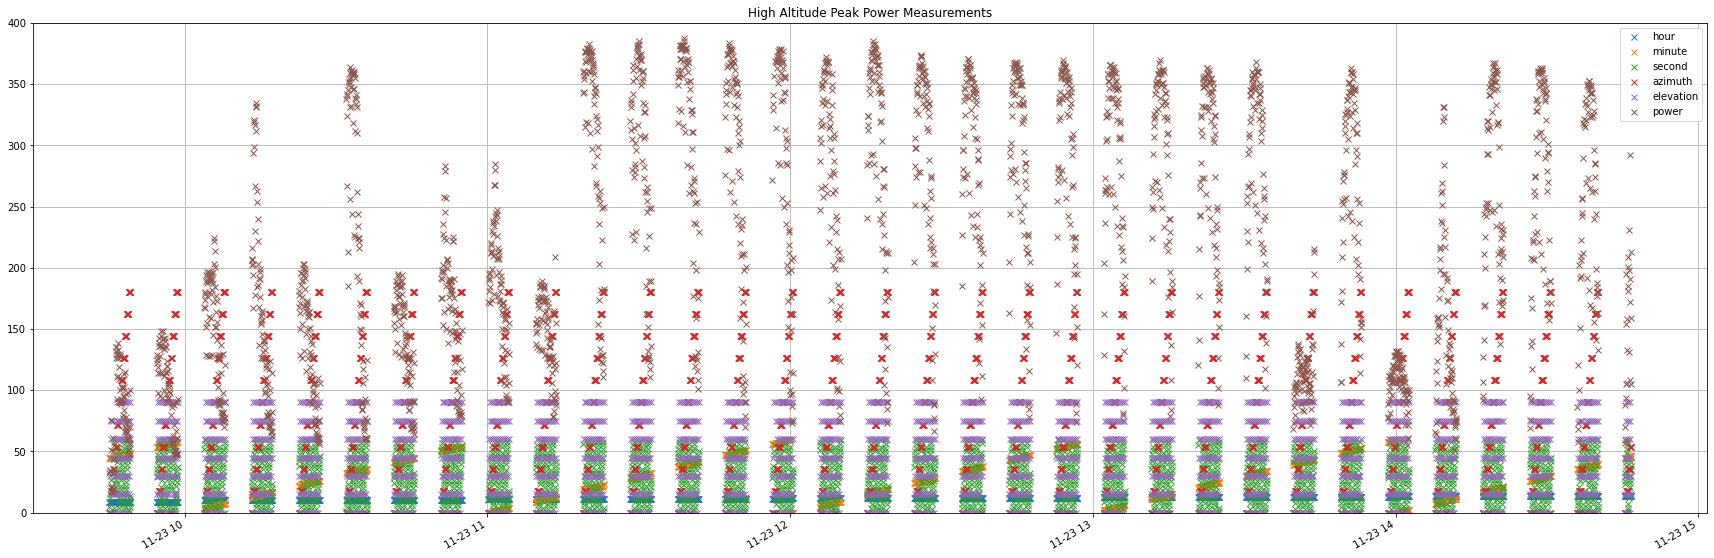

In [17]:
high_altitude.plot(figsize=(30,10), title='High Altitude Peak Power Measurements', grid=True, marker='x', markersize=6, linestyle='None', ylim=(0,400))

<AxesSubplot:title={'center':'Low Altitude Peak Power Measurements'}>

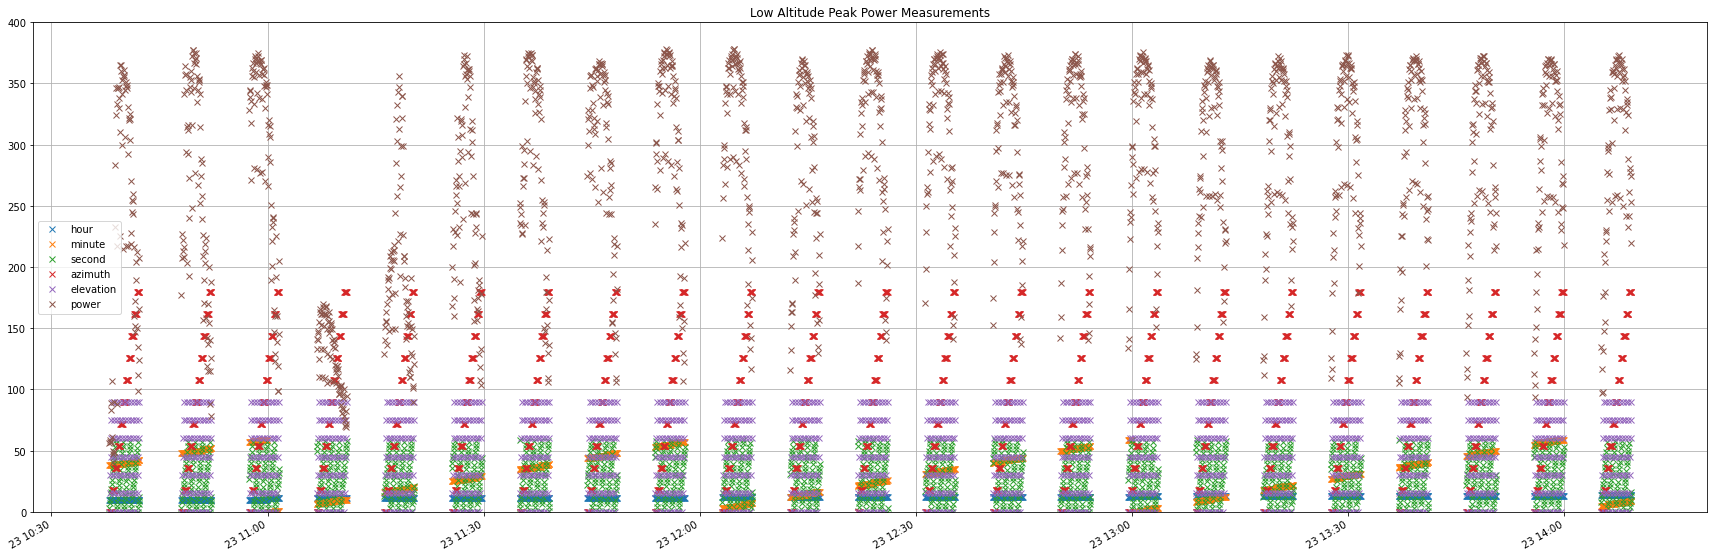

In [18]:
low_altitude.plot(figsize=(30,10), title='Low Altitude Peak Power Measurements', grid=True, marker='x', markersize=6, linestyle='None', ylim=(0,400))

## Train test split

In [19]:
X_low_train = low_altitude.sample(frac=0.8, random_state=2)
X_low_test = low_altitude.drop(X_low_train.index)

y_low_train = X_low_train.pop("power")
y_low_test = X_low_test.pop("power")

In [20]:
X_high_train = high_altitude.sample(frac=0.8, random_state=2)
X_high_test = high_altitude.drop(X_high_train.index)

y_high_train = X_high_train.pop("power")
y_high_test = X_high_test.pop("power")

In [21]:
y_low_train.describe()

count    1417.000000
mean      279.540579
std        82.386542
min        49.000000
25%       227.000000
50%       301.000000
75%       351.000000
max       378.000000
Name: power, dtype: float64

In [22]:
y_high_train.describe()

count    1967.000000
mean      224.564311
std       104.227067
min         0.000000
25%       129.000000
50%       216.000000
75%       333.000000
max       388.000000
Name: power, dtype: float64

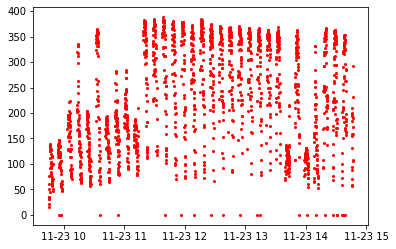

In [23]:
plt.plot(y_high_train, 'or', markersize=2)

In [24]:
normalizer_low = Normalization(axis=-1)
normalizer_low.adapt(np.array(X_low_train))

print(normalizer_low.mean.numpy())

2022-07-12 12:32:07.134387: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-12 12:32:07.134656: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-07-12 12:32:07.177872: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-12 12:32:07.244142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-12 12:32:07.257039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

[[11.871558 30.616798 29.044462 88.81864  45.719826]]


In [25]:
first_sample = np.array(X_low_train[:1])

with np.printoptions(precision=2, suppress=True):
  print(np.sort(first_sample))
  print(np.sort(normalizer_low(first_sample).numpy()))


[[ 0 11 15 26 44]]
[[-1.56 -1.02 -0.8  -0.18  0.74]]


# Baseline Dataset

## Regression using MLP

In [26]:
def create_regressor(normalizer):
  reg = Sequential([
  normalizer,
  Dense(units=256, activation='relu'),
  Dropout(0.3),
  Dense(units=128, activation='relu'),
  Dense(units=1)
])

  return reg

In [27]:
callbacks=[tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-10, verbose=1), tf.keras.callbacks.EarlyStopping(patience=30)]
metrics = [tf.keras.metrics.MeanSquaredError()]

In [28]:
def plot_metrics(history):

  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(20,10)
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_title('loss (MAE)')
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('error')
  ax1.legend()
  ax1.grid(True)

  ax2.plot(history.history['mean_squared_error'], label='mse')
  ax2.plot(history.history['val_mean_squared_error'], label='val_mse')
  ax2.set_title('metric (MSE)')
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('error')
  ax2.legend()
  ax2.grid(True)

### Regression on Low Altitude

In [29]:
reg_low = create_regressor(normalizer_low)
reg_low.predict(X_low_train[:10])

2022-07-12 12:32:07.634776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[ 0.12242815],
       [-0.11083279],
       [ 0.10606509],
       [-0.07049257],
       [-0.02257229],
       [-0.12289104],
       [ 0.15685952],
       [ 0.06745135],
       [-0.1232888 ],
       [ 0.11768232]], dtype=float32)

In [30]:
reg_low.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense (Dense)               (None, 256)               1536      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34,572
Trainable params: 34,561
Non-trainable params: 11
___________________________________________________

In [31]:
reg_low.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mae", metrics=metrics)

In [32]:
history = reg_low.fit(X_low_train, y_low_train, epochs=1000, validation_split=0.2, callbacks=callbacks)

Epoch 1/1000
11/36 [========>.....................] - ETA: 0s - loss: 146.8306 - mean_squared_error: 30774.9180

2022-07-12 12:32:07.942452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 1s 9ms/step - loss: 108.5427 - mean_squared_error: 18278.9004 - val_loss: 69.3321 - val_mean_squared_error: 8466.0586 - lr: 0.1000
Epoch 2/1000
21/36 [================>.............] - ETA: 0s - loss: 79.0850 - mean_squared_error: 9987.3408 

2022-07-12 12:32:08.344667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 0s 6ms/step - loss: 73.8678 - mean_squared_error: 8716.8887 - val_loss: 48.1190 - val_mean_squared_error: 3118.5542 - lr: 0.1000
Epoch 3/1000
36/36 [==============================] - 0s 6ms/step - loss: 52.2633 - mean_squared_error: 4565.4878 - val_loss: 77.8785 - val_mean_squared_error: 9234.7607 - lr: 0.1000
Epoch 4/1000
36/36 [==============================] - 0s 6ms/step - loss: 57.4177 - mean_squared_error: 5237.8105 - val_loss: 34.7125 - val_mean_squared_error: 1900.9949 - lr: 0.1000
Epoch 5/1000
36/36 [==============================] - 0s 6ms/step - loss: 44.3897 - mean_squared_error: 3245.8105 - val_loss: 35.9200 - val_mean_squared_error: 2152.3865 - lr: 0.1000
Epoch 6/1000
36/36 [==============================] - 0s 6ms/step - loss: 39.5467 - mean_squared_error: 2883.5229 - val_loss: 31.5496 - val_mean_squared_error: 1755.6305 - lr: 0.1000
Epoch 7/1000
36/36 [==============================] - 0s 6ms/step - loss: 37.8160 - mean_squared_e

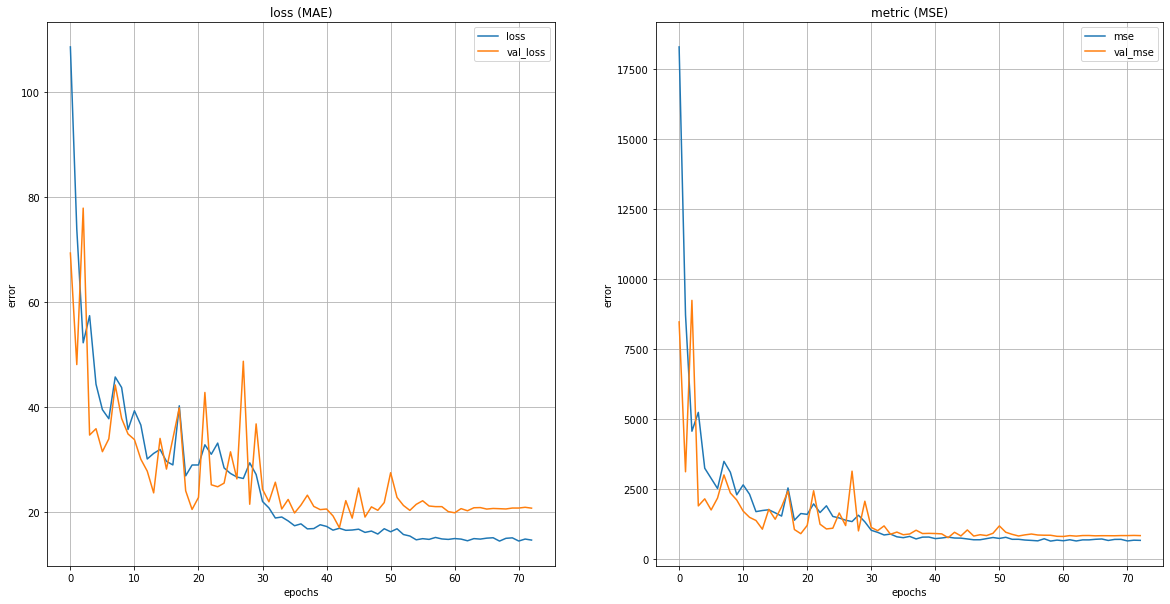

In [33]:
plot_metrics(history)

In [34]:
results = reg_low.evaluate(X_low_test, y_low_test)

12/12 [==============================] - 0s 6ms/step - loss: 20.6364 - mean_squared_error: 830.4291


### Regression on High Altitude

In [35]:
normalizer_high = Normalization(axis=-1)
normalizer_high.adapt(np.array(X_high_train))

print(normalizer_high.mean.numpy())

[[11.747841 29.50585  29.623283 89.49671  45.289783]]


2022-07-12 12:32:25.158241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-12 12:32:25.168794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [36]:
first_sample = np.array(X_high_train[:1])

with np.printoptions(precision=2, suppress=True):
  print(np.sort(first_sample))
  print(np.sort(normalizer_high(first_sample).numpy()))

[[ 11  15  40  50 144]]
[[-1.01 -0.5   0.61  0.96  1.17]]


In [37]:
reg_high = create_regressor(normalizer_high)
reg_high.predict(X_high_train[:10])

2022-07-12 12:32:25.406063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[ 0.13749868],
       [ 0.09021375],
       [ 0.08332359],
       [ 0.00684475],
       [ 0.08060914],
       [-0.11596026],
       [ 0.02168257],
       [ 0.09626028],
       [ 0.14609218],
       [ 0.00819618]], dtype=float32)

In [38]:
reg_high.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 5)                11        
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 256)               1536      
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34,572
Trainable params: 34,561
Non-trainable params: 11
_________________________________________________

In [39]:
reg_high.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mae', metrics=metrics)

In [40]:
history = reg_high.fit(X_high_train, y_high_train, epochs=1000, validation_split=0.2, callbacks=callbacks)

Epoch 1/1000
20/50 [===========>..................] - ETA: 0s - loss: 122.1245 - mean_squared_error: 15206.3037

2022-07-12 12:32:25.637816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 8ms/step - loss: 104.2177 - mean_squared_error: 14465.0859 - val_loss: 92.9681 - val_mean_squared_error: 14737.1748 - lr: 0.1000
Epoch 2/1000
21/50 [===========>..................] - ETA: 0s - loss: 92.8642 - mean_squared_error: 13831.0537 

2022-07-12 12:32:26.044731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 0s 6ms/step - loss: 81.1405 - mean_squared_error: 10900.6455 - val_loss: 59.0011 - val_mean_squared_error: 6222.3726 - lr: 0.1000
Epoch 3/1000
50/50 [==============================] - 0s 6ms/step - loss: 64.5843 - mean_squared_error: 7305.2827 - val_loss: 52.0571 - val_mean_squared_error: 4514.9336 - lr: 0.1000
Epoch 4/1000
50/50 [==============================] - 0s 6ms/step - loss: 52.5459 - mean_squared_error: 5183.8813 - val_loss: 54.4291 - val_mean_squared_error: 4792.6104 - lr: 0.1000
Epoch 5/1000
50/50 [==============================] - 0s 6ms/step - loss: 63.8323 - mean_squared_error: 7114.8413 - val_loss: 53.7391 - val_mean_squared_error: 4790.2866 - lr: 0.1000
Epoch 6/1000
50/50 [==============================] - 0s 6ms/step - loss: 54.6726 - mean_squared_error: 5530.5044 - val_loss: 52.4204 - val_mean_squared_error: 4213.3516 - lr: 0.1000
Epoch 7/1000
50/50 [==============================] - 0s 6ms/step - loss: 50.0441 - mean_squared_

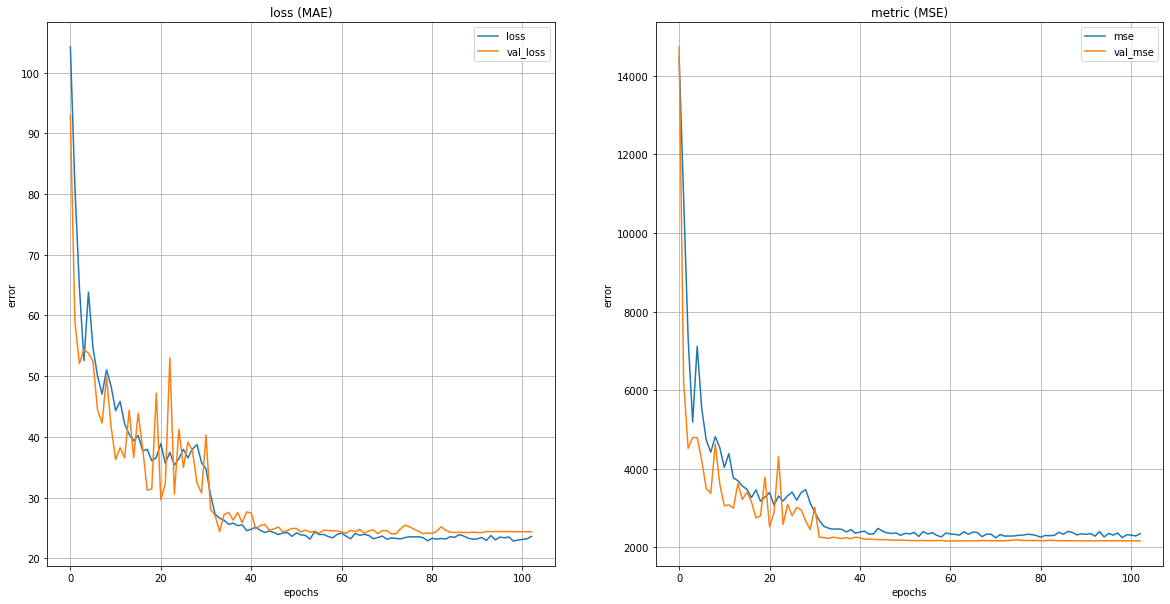

In [41]:
plot_metrics(history)

In [42]:
results = reg_high.evaluate(X_high_test, y_high_test)

16/16 [==============================] - 0s 6ms/step - loss: 25.5664 - mean_squared_error: 2433.2080


## Forecasting using regression

- Create a time vector for the rest of the day (do i need to resample the existing time vector before?)
- Extend the elevation and azimuth angles vectors
- Use the trained regressor to predict output power for the rest of the day
- 

In [85]:
high_altitude_time = high_altitude.index.values
high_altitude_time[:10]

array(['2016-11-23T09:45:05.000000000', '2016-11-23T09:45:12.000000000',
       '2016-11-23T09:45:15.000000000', '2016-11-23T09:45:18.000000000',
       '2016-11-23T09:45:21.000000000', '2016-11-23T09:45:27.000000000',
       '2016-11-23T09:45:32.000000000', '2016-11-23T09:45:44.000000000',
       '2016-11-23T09:45:50.000000000', '2016-11-23T09:45:55.000000000'],
      dtype='datetime64[ns]')

In [80]:
high_altitude_time = high_altitude.index.values
last_time = high_altitude_time[-1:][0]
last_time = last_time + pd.Timedelta(seconds=1)
last_time

Timestamp('2016-11-23 14:46:42')

In [73]:
#prolong high_altitude_times untill the evening of the 23rd of November
import datetime as dt
high_altitude_time = np.append(high_altitude_time, np.arange(pd.to_datetime('2016-11-23T14:46:41'), pd.to_datetime('2016-11-23 21:00:00'), dt.timedelta(seconds=1)))
high_altitude_time = high_altitude_time.astype(dt.datetime)
high_altitude_time = pd.to_datetime(high_altitude_time)
# high_altitude_time = high_altitude_time.reset_index(drop=True)
high_altitude_time = high_altitude_time.values
high_altitude_time

numpy.datetime64('2016-11-23T09:45:05.000000000')

In [ ]:
#prolong high_altitude_times from last_time to the 20:00 of the 23rd of November

## Forecasting with NeuralPropphet

In [56]:
high_altitude.head()

,hour,minute,second,azimuth,elevation,power
2016-11-23 09:45:05,9,45,5,0,0,32
2016-11-23 09:45:12,9,45,12,0,30,34
2016-11-23 09:45:15,9,45,15,0,45,35
2016-11-23 09:45:18,9,45,18,0,60,51
2016-11-23 09:45:21,9,45,21,0,75,76


In [57]:
dataset = pd.DataFrame({"ds":high_altitude.index, "y":high_altitude['power']})

In [58]:
dataset

,ds,y
2016-11-23 09:45:05,2016-11-23 09:45:05,32
2016-11-23 09:45:12,2016-11-23 09:45:12,34
2016-11-23 09:45:15,2016-11-23 09:45:15,35
2016-11-23 09:45:18,2016-11-23 09:45:18,51
2016-11-23 09:45:21,2016-11-23 09:45:21,76
...,...,...
2016-11-23 14:46:27,2016-11-23 14:46:27,172
2016-11-23 14:46:30,2016-11-23 14:46:30,108
2016-11-23 14:46:35,2016-11-23 14:46:35,159
2016-11-23 14:46:38,2016-11-23 14:46:38,213


In [59]:
from neuralprophet import NeuralProphet

In [60]:
m = NeuralProphet(weekly_seasonality=False)
metrics = m.fit(dataset)

INFO - (NP.df_utils._infer_frequency) - Major frequency 3S corresponds to 83.489% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as 3S
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 149
 98%|█████████▊| 132/135 [00:00<00:00, 909.36it/s]
INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.82E-01, min: 1.25E-03
 94%|█████████▍| 127/135 [00:00<00:00, 1142.92it/s]
INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.82E-01, min: 2.71E-03
INFO - (N

In [61]:
forecast=m.predict(toforecast)
fig = m.plot(forecast)

NameError: name 'toforecast' is not defined

In [ ]:
future = m.make_future_dataframe(df = dataset, periods = 1000)
forecast = m.predict(future)
forecast.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency 3S corresponds to 83.489% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 3S
INFO - (NP.df_utils._infer_frequency) - Major frequency 3S corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 3S
INFO - (NP.df_utils._infer_frequency) - Major frequency 3S corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 3S
WARNING - (py.warnings._showwarnmsg) - /Users/andrea/miniforge3/envs/ml/lib/python3.9/site-packages/neuralprophet/forecaster.py:1406: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



,ds,y,yhat1,residual1,trend
0,2016-11-23 14:46:44,None,245.755890,NaN,245.755890
1,2016-11-23 14:46:47,None,245.827896,NaN,245.827896
2,2016-11-23 14:46:50,None,245.900009,NaN,245.900009
3,2016-11-23 14:46:53,None,245.972061,NaN,245.972061
4,2016-11-23 14:46:56,None,246.044113,NaN,246.044113


In [ ]:
forecast.tail()

,ds,y,yhat1,residual1,trend
995,2016-11-23 15:36:29,None,317.464447,NaN,317.464447
996,2016-11-23 15:36:32,None,317.536499,NaN,317.536499
997,2016-11-23 15:36:35,None,317.608612,NaN,317.608612
998,2016-11-23 15:36:38,None,317.680664,NaN,317.680664
999,2016-11-23 15:36:41,None,317.752716,NaN,317.752716


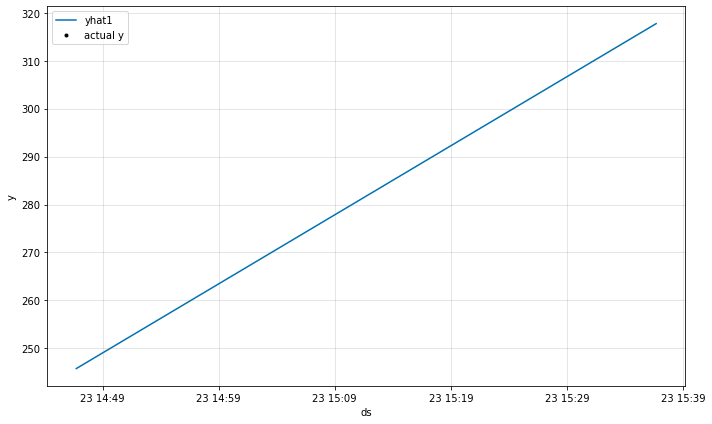

In [ ]:
plot1 = m.plot(forecast)